# JupyterHub Notebook

### This notebook server is hosted on the OpenShift platform which provides a separate server for each individual user. The platform takes care of the provisioning of the server and allocating related to storage.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import watermark
# import s3fs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from minio import Minio
from verta import Client
from minio.error import ResponseError
import os
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

# import tools as tools
%matplotlib inline
%load_ext watermark

In [2]:
%watermark -n -v -m -g -iv


matplotlib 3.3.3
numpy      1.19.4
pandas     1.1.5
watermark  2.0.2
seaborn    0.11.0
Tue Aug 17 2021 

CPython 3.6.8
IPython 7.16.1

compiler   : GCC 8.3.1 20191121 (Red Hat 8.3.1-5)
system     : Linux
release    : 4.18.0-240.10.1.el8_3.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
Git hash   : 392a1f0f09791f68299959d2f17d8ae855c26be0


In [3]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

### In this next section, on the second line, insert the value you retrieved from Minio object storage earlier - representing the fully qualified name of your csv file in Minio. This is the file pushed by the data engineer in the format: full_data_csv{USERNAME}/{FILENAME}.csv. 
#### In my case this value is: full_data_csvuser29/part-00000-59149e08-583c-46a5-bfa0-0b3abecbf1a3-c000.csv (yours will be different)
### We refer to this fully qualified name in the Github instructions as CSV-FILE

In [4]:
minioClient = get_s3_server()
data_file = minioClient.fget_object("data", "full_data_csvuser29/part-00000-abfb5786-ae6b-4b7e-9f95-5af833c9f56b-c000.csv", "/tmp/data.csv")
data_file_version = data_file.version_id
data = pd.read_csv('/tmp/data.csv')
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Premium,RelationshipManager,PrimaryChannel,HasCreditCard,...,IncomeProtection,WealthManagement,HomeEquityLoans,MoneyMarketAccount,CreditRating,PaperlessBilling,AccountType,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,Mobile,No,...,No,No,No,No,Month-to-month,Yes,Checking,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Branch,No,...,Yes,No,Yes,Yes,Month-to-month,No,Checking,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,Not Available,...,Not Available,Not Available,Not Available,Not Available,One year,No,Savings,20.65,330.60,No
3,496,Male,0,No,No,22,No,Not available,Mobile,No,...,Yes,No,No,Yes,One year,Yes,Brokerage,43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,Mobile,Yes,...,Yes,Yes,No,Yes,One year,No,Credit Card,74.10,5222.30,No


### Use pandas.DataFrame functions
- _shape_ to return the dimensionality
- _info_ to print a concise summary of the DataFrame
- _describe_ to generate descriptive statistics of the DataFrame's columns
- _isnull().sum()_ to sum the empty values
- finally determine Churn and Total Changes 


In [5]:
data.shape

(7043, 21)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customerID           7043 non-null   int64  
 1   gender               7043 non-null   object 
 2   SeniorCitizen        7043 non-null   int64  
 3   Partner              7043 non-null   object 
 4   Dependents           7043 non-null   object 
 5   tenure               7043 non-null   int64  
 6   Premium              7043 non-null   object 
 7   RelationshipManager  7043 non-null   object 
 8   PrimaryChannel       7043 non-null   object 
 9   HasCreditCard        7043 non-null   object 
 10  DebitCard            7043 non-null   object 
 11  IncomeProtection     7043 non-null   object 
 12  WealthManagement     7043 non-null   object 
 13  HomeEquityLoans      7043 non-null   object 
 14  MoneyMarketAccount   7043 non-null   object 
 15  CreditRating         7043 non-null   o

In [7]:
data.describe()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000
mean,3522.000000,0.162147,32.371149,64.761692,2283.300441
std,2033.283305,0.368612,24.559481,30.090047,2266.771362
min,1.000000,0.000000,0.000000,18.250000,18.800000
25%,1761.500000,0.000000,9.000000,35.500000,401.450000
50%,3522.000000,0.000000,29.000000,70.350000,1397.475000
75%,5282.500000,0.000000,55.000000,89.850000,3794.737500
max,7043.000000,1.000000,72.000000,118.750000,8684.800000


In [8]:
data.isnull().sum()

customerID              0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
tenure                  0
Premium                 0
RelationshipManager     0
PrimaryChannel          0
HasCreditCard           0
DebitCard               0
IncomeProtection        0
WealthManagement        0
HomeEquityLoans         0
MoneyMarketAccount      0
CreditRating            0
PaperlessBilling        0
AccountType             0
MonthlyCharges          0
TotalCharges           11
Churn                   0
dtype: int64

Text(0, 0.5, 'Count')

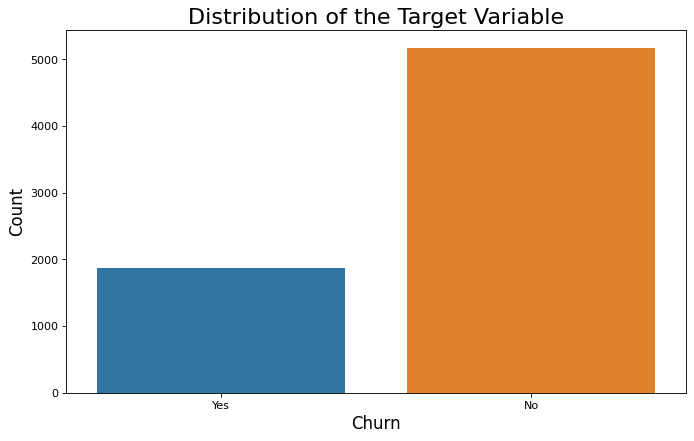

In [9]:
fig = plt.figure(figsize=(10,6), dpi=80)
ax = sns.countplot(x="Churn", data=data)
ax.set_title('Distribution of the Target Variable', fontsize=20)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [10]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

Text(0.5, 1.0, 'Churn count by Credit Rating')

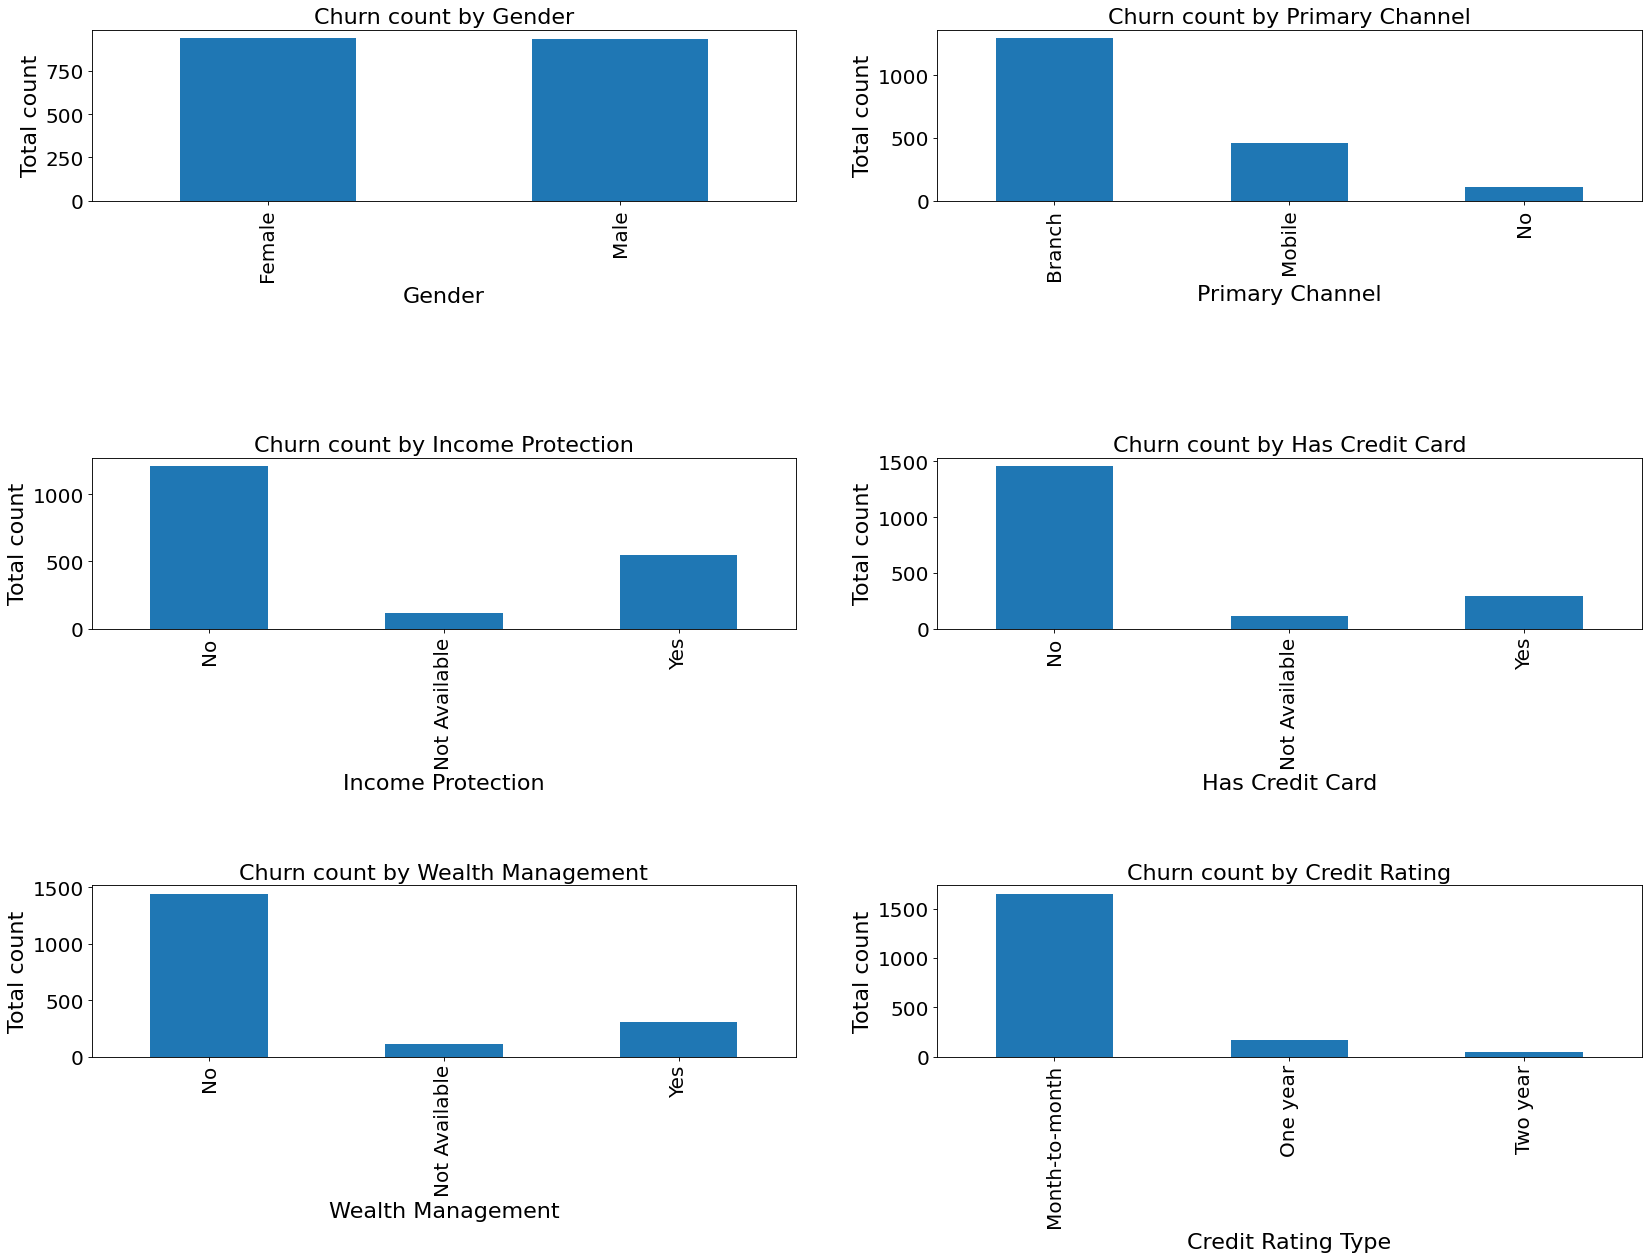

In [11]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(25,17), dpi = 80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=1.5)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)

data.groupby('gender').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Total count',fontsize = 20)
ax1.set_xlabel('Gender',fontsize = 20)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Gender',fontsize = 20)

data.groupby('PrimaryChannel').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Total count',fontsize = 20)
ax2.set_xlabel('Primary Channel',fontsize = 20)
ax2.tick_params(labelsize = 18)
ax2.set_title('Churn count by Primary Channel',fontsize = 20)

data.groupby('IncomeProtection').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Total count',fontsize = 20)
ax3.set_xlabel('Income Protection',fontsize = 20)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Income Protection',fontsize = 20)

data.groupby('HasCreditCard').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Total count',fontsize = 20)
ax4.set_xlabel('Has Credit Card',fontsize = 20)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by Has Credit Card',fontsize = 20)

data.groupby('WealthManagement').Churn.sum().plot(kind='bar',ax=ax5)
ax5.set_ylabel('Total count',fontsize = 20)
ax5.set_xlabel('Wealth Management',fontsize = 20)
ax5.tick_params(labelsize = 18)
ax5.set_title('Churn count by Wealth Management',fontsize = 20)

data.groupby('CreditRating').Churn.sum().plot(kind='bar',ax=ax6)
ax6.set_ylabel('Total count',fontsize = 20)
ax6.set_xlabel('Credit Rating Type',fontsize = 20)
ax6.tick_params(labelsize = 18)
ax6.set_title('Churn count by Credit Rating',fontsize = 20)


In [12]:
data.replace(" ", np.nan, inplace=True)

In [13]:
data.isna().sum()

customerID              0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
tenure                  0
Premium                 0
RelationshipManager     0
PrimaryChannel          0
HasCreditCard           0
DebitCard               0
IncomeProtection        0
WealthManagement        0
HomeEquityLoans         0
MoneyMarketAccount      0
CreditRating            0
PaperlessBilling        0
AccountType             0
MonthlyCharges          0
TotalCharges           11
Churn                   0
dtype: int64

In [14]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [15]:
mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)
# Now we know that total charges has nan values
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
Premium                0
RelationshipManager    0
PrimaryChannel         0
HasCreditCard          0
DebitCard              0
IncomeProtection       0
WealthManagement       0
HomeEquityLoans        0
MoneyMarketAccount     0
CreditRating           0
PaperlessBilling       0
AccountType            0
MonthlyCharges         0
TotalCharges           0
Churn                  0
dtype: int64

Text(9.942158564814818, 0.5, 'Total Charges')

<Figure size 800x640 with 0 Axes>

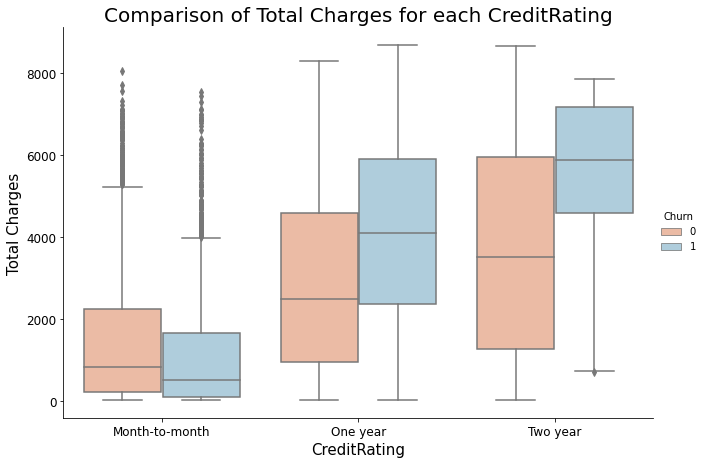

In [16]:
plt.figure(figsize=(10,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="CreditRating", y="TotalCharges", hue="Churn", kind="box", data=data, height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparison of Total Charges for each CreditRating',fontsize = 20)
plt.xlabel('CreditRating',fontsize = 15)
plt.ylabel('Total Charges',fontsize = 15)